# Machine Learning Model Construction for Single Cell RNA-Seq Clustering Parameter Evaluation Results

## Method

Tabula Muris Droplet, Tabula Muris Spike and Zhengmix datasets were downloaded using R/Bioconductor. Datasets are preprocessed using **scran**. For each dataset, *Shared Nearest Neighbour* based graph construction and graph clustering using 3 popular algorithms, Walktrap, Louvain and Leiden algorithms from **igraph** package.
SNN graphs for each dataset with *number of neighbours* parameter from 1 to 50, Highly Variant Genes as 500, 1000, 1500 and 2000 were constructed. *DenoisePCA* function from scran package is used for PCA. Adjusted Rand Index used for clustering comparison with cell labels. Clusterings with ARI higher than 0.65 are labelled as accepted.

### Applying Machine Learning Algorithms to build a model and show importances of parameters

#### Required Packages

In [4]:
import numpy as np
import pandas as pd

from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split

import lightgbm
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, r2_score, roc_auc_score, roc_curve, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from catboost import CatBoostClassifier, Pool

#### Data Import (Preprocessed using R)

In [5]:
ari_results = pd.read_csv("encoded_all_results_w_ari.txt" , sep = "\t")

In [3]:
ari_results.sample(n = 5)

,Number_of_Neighbours,Number_of_PCs,Number_of_Cells,Number_of_HVGs,AlgorithmLeiden,AlgorithmLouvain,AlgorithmWalktrap,Exp_TypeDroplet,acceptable_ari
4789,40,30,11248,2000,0,1,0,1,0
18437,38,6,3994,1500,0,0,1,1,1
2786,37,9,3652,500,0,1,0,1,1
18676,27,7,6498,500,0,1,0,1,0
6046,47,15,2500,1500,1,0,0,1,1


In [3]:
ari_results.head()

,Number_of_Neighbours,Number_of_PCs,Number_of_Cells,Number_of_HVGs,AlgorithmLeiden,AlgorithmLouvain,AlgorithmWalktrap,Exp_TypeDroplet,acceptable_ari
0,1,15,2500,500,0,0,1,1,0
1,2,15,2500,500,0,0,1,1,0
2,3,15,2500,500,0,0,1,1,0
3,4,15,2500,500,0,0,1,1,0
4,5,15,2500,500,0,0,1,1,0


In [6]:
ari_labels = ari_results["acceptable_ari"]

In [7]:
ari_features = ari_results.drop(["acceptable_ari"] , axis = 1)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(ari_features, ari_labels ,test_size=.25,random_state = 8764)

In [9]:
y_train.sum()

2781

In [10]:
y_test.sum()

919

#### LazyClassifier Package is used to find the optimum algorithm

In [11]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)

In [10]:
models,predictions = clf.fit(X_train, X_test, y_train, y_test)

100%|██████████| 29/29 [00:20<00:00,  1.44it/s]


In [11]:
print(models)

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
XGBClassifier                      0.97               0.96     0.96      0.97   
LGBMClassifier                     0.97               0.96     0.96      0.97   
BaggingClassifier                  0.97               0.95     0.95      0.97   
RandomForestClassifier             0.97               0.95     0.95      0.97   
ExtraTreesClassifier               0.97               0.95     0.95      0.97   
DecisionTreeClassifier             0.96               0.94     0.94      0.96   
ExtraTreeClassifier                0.94               0.91     0.91      0.94   
KNeighborsClassifier               0.94               0.90     0.90      0.94   
LabelPropagation                   0.94               0.89     0.89      0.94   
LabelSpreading                     0.94               0.89     0.89      0.94   
AdaBoostClassifier          

#### LightGBM is selected as optimum model. Another model with default parameters are also built.

In [12]:
lgb_model = LGBMClassifier().fit(X_train, y_train)

In [13]:
y_pred = lgb_model.predict(X_test)

#### Feature Importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

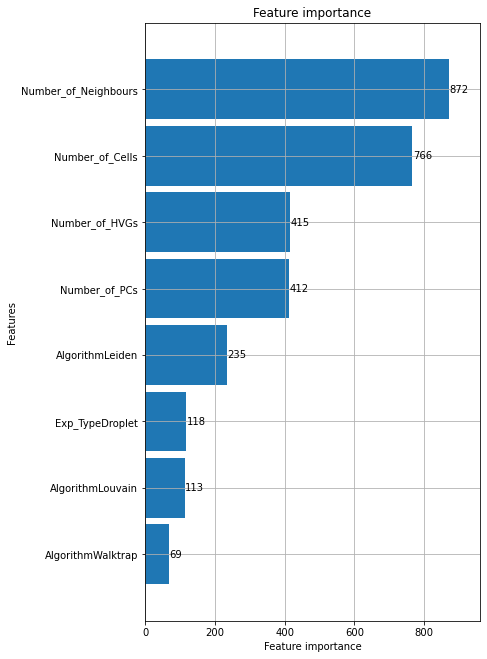

In [14]:
plt.rcParams["figure.figsize"] = (6, 11)

lightgbm.plot_importance(lgb_model, max_num_features = 60, height=.9)

#### Logistic Regression

In [15]:
loj_model = LogisticRegression(solver = "liblinear").fit(X_train,y_train)

In [16]:
loj_model.intercept_

array([-2.47970868])

In [17]:
loj_model.coef_

array([[ 6.58663889e-02, -2.85197810e-02, -1.88582600e-04,
         2.79818731e-06, -5.14732300e-01, -8.53688576e-01,
        -1.11128780e+00,  1.65985717e+00]])

In [18]:
loj_model.predict(X_test)[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [19]:
y_pred = loj_model.predict(X_test)

In [20]:
confusion_matrix(y_test, y_pred)

array([[3846,  185],
       [ 714,  205]], dtype=int64)

In [21]:
accuracy_score(y_test, y_pred)

0.8183838383838384

In [22]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.95      0.90      4031
           1       0.53      0.22      0.31       919

    accuracy                           0.82      4950
   macro avg       0.68      0.59      0.60      4950
weighted avg       0.78      0.82      0.79      4950



#### ROC Curve for Logistic Regression

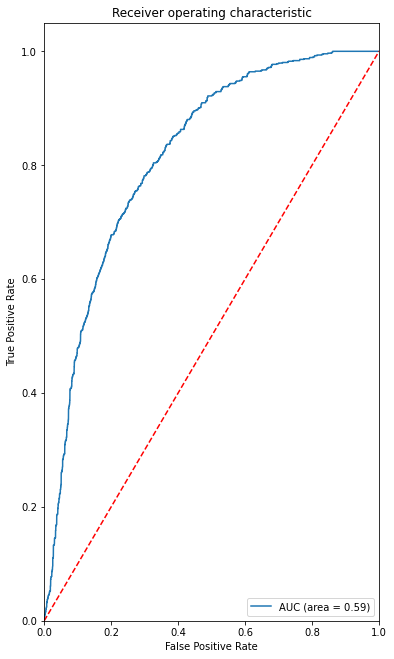

In [23]:
logit_roc_auc = roc_auc_score(y_test, loj_model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, loj_model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='AUC (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [24]:
print(accuracy_score(y_test, y_pred))

0.8183838383838384


In [25]:
cross_val_score(loj_model, X_test, y_test, cv = 10).mean()

0.8171717171717171

#### CatBoost Algorithm

In [12]:
catb = CatBoostClassifier()

In [13]:
catb_params = {"iterations":[200,500,100,300],
              "learning_rate":[0.01, 0.03, 0.05 , 0.1],
              "depth":[4,5,8,10]}

In [14]:
catb_cv_model = GridSearchCV(catb, catb_params, 
                             cv = 5, n_jobs = -1, verbose = 2).fit(X_train, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
0:	learn: 0.6374243	total: 156ms	remaining: 46.6s
1:	learn: 0.5828156	total: 179ms	remaining: 26.7s
2:	learn: 0.5357410	total: 199ms	remaining: 19.7s
3:	learn: 0.4923353	total: 218ms	remaining: 16.2s
4:	learn: 0.4547273	total: 239ms	remaining: 14.1s
5:	learn: 0.4220488	total: 264ms	remaining: 13s
6:	learn: 0.3928937	total: 281ms	remaining: 11.7s
7:	learn: 0.3674892	total: 303ms	remaining: 11.1s
8:	learn: 0.3446618	total: 326ms	remaining: 10.5s
9:	learn: 0.3229837	total: 348ms	remaining: 10.1s
10:	learn: 0.3055727	total: 373ms	remaining: 9.79s
11:	learn: 0.2875716	total: 393ms	remaining: 9.44s
12:	learn: 0.2722296	total: 417ms	remaining: 9.21s
13:	learn: 0.2597448	total: 442ms	remaining: 9.02s
14:	learn: 0.2483128	total: 465ms	remaining: 8.83s
15:	learn: 0.2363639	total: 487ms	remaining: 8.64s
16:	learn: 0.2261635	total: 513ms	remaining: 8.54s
17:	learn: 0.2177261	total: 540ms	remaining: 8.46s
18:	learn: 0.2087974	total: 562m

166:	learn: 0.0642063	total: 3.72s	remaining: 2.96s
167:	learn: 0.0640369	total: 3.74s	remaining: 2.94s
168:	learn: 0.0640131	total: 3.75s	remaining: 2.9s
169:	learn: 0.0637282	total: 3.77s	remaining: 2.88s
170:	learn: 0.0635387	total: 3.79s	remaining: 2.85s
171:	learn: 0.0633339	total: 3.8s	remaining: 2.83s
172:	learn: 0.0631773	total: 3.82s	remaining: 2.81s
173:	learn: 0.0630345	total: 3.84s	remaining: 2.78s
174:	learn: 0.0629156	total: 3.86s	remaining: 2.76s
175:	learn: 0.0627127	total: 3.87s	remaining: 2.73s
176:	learn: 0.0625932	total: 3.89s	remaining: 2.71s
177:	learn: 0.0624418	total: 3.91s	remaining: 2.68s
178:	learn: 0.0623204	total: 3.93s	remaining: 2.66s
179:	learn: 0.0621432	total: 3.95s	remaining: 2.63s
180:	learn: 0.0619789	total: 3.97s	remaining: 2.61s
181:	learn: 0.0617565	total: 3.99s	remaining: 2.58s
182:	learn: 0.0616193	total: 4s	remaining: 2.56s
183:	learn: 0.0615006	total: 4.02s	remaining: 2.54s
184:	learn: 0.0613204	total: 4.04s	remaining: 2.51s
185:	learn: 0.061

In [15]:
catb_cv_model.best_params_

{'depth': 10, 'iterations': 300, 'learning_rate': 0.03}

In [16]:
catb_tuned = CatBoostClassifier(depth= 10, 
                                iterations= 500, 
                                learning_rate= 0.03).fit(X_train, y_train)

0:	learn: 0.6374243	total: 10.8ms	remaining: 5.38s
1:	learn: 0.5828156	total: 26.9ms	remaining: 6.71s
2:	learn: 0.5357410	total: 42.2ms	remaining: 7s
3:	learn: 0.4923353	total: 54.3ms	remaining: 6.73s
4:	learn: 0.4547273	total: 71ms	remaining: 7.03s
5:	learn: 0.4220488	total: 87.7ms	remaining: 7.22s
6:	learn: 0.3928937	total: 99ms	remaining: 6.97s
7:	learn: 0.3674892	total: 112ms	remaining: 6.89s
8:	learn: 0.3446618	total: 123ms	remaining: 6.71s
9:	learn: 0.3229837	total: 136ms	remaining: 6.68s
10:	learn: 0.3055727	total: 147ms	remaining: 6.56s
11:	learn: 0.2875716	total: 160ms	remaining: 6.5s
12:	learn: 0.2722296	total: 173ms	remaining: 6.47s
13:	learn: 0.2597448	total: 185ms	remaining: 6.42s
14:	learn: 0.2483128	total: 197ms	remaining: 6.37s
15:	learn: 0.2363639	total: 208ms	remaining: 6.29s
16:	learn: 0.2261635	total: 221ms	remaining: 6.27s
17:	learn: 0.2177261	total: 231ms	remaining: 6.19s
18:	learn: 0.2087974	total: 243ms	remaining: 6.15s
19:	learn: 0.2013848	total: 255ms	remainin

175:	learn: 0.0627127	total: 1.93s	remaining: 3.54s
176:	learn: 0.0625932	total: 1.94s	remaining: 3.53s
177:	learn: 0.0624418	total: 1.95s	remaining: 3.52s
178:	learn: 0.0623204	total: 1.96s	remaining: 3.51s
179:	learn: 0.0621432	total: 1.97s	remaining: 3.5s
180:	learn: 0.0619789	total: 1.98s	remaining: 3.48s
181:	learn: 0.0617565	total: 1.99s	remaining: 3.47s
182:	learn: 0.0616193	total: 2s	remaining: 3.46s
183:	learn: 0.0615006	total: 2.01s	remaining: 3.45s
184:	learn: 0.0613204	total: 2.02s	remaining: 3.44s
185:	learn: 0.0611901	total: 2.03s	remaining: 3.42s
186:	learn: 0.0610544	total: 2.04s	remaining: 3.41s
187:	learn: 0.0608987	total: 2.05s	remaining: 3.4s
188:	learn: 0.0606976	total: 2.06s	remaining: 3.39s
189:	learn: 0.0605550	total: 2.07s	remaining: 3.38s
190:	learn: 0.0604868	total: 2.08s	remaining: 3.36s
191:	learn: 0.0603359	total: 2.09s	remaining: 3.35s
192:	learn: 0.0602017	total: 2.1s	remaining: 3.34s
193:	learn: 0.0600000	total: 2.11s	remaining: 3.33s
194:	learn: 0.0597

351:	learn: 0.0456913	total: 3.63s	remaining: 1.53s
352:	learn: 0.0456347	total: 3.64s	remaining: 1.52s
353:	learn: 0.0455785	total: 3.65s	remaining: 1.5s
354:	learn: 0.0454730	total: 3.66s	remaining: 1.5s
355:	learn: 0.0454034	total: 3.67s	remaining: 1.48s
356:	learn: 0.0453356	total: 3.68s	remaining: 1.47s
357:	learn: 0.0452557	total: 3.69s	remaining: 1.46s
358:	learn: 0.0452041	total: 3.7s	remaining: 1.45s
359:	learn: 0.0451352	total: 3.71s	remaining: 1.44s
360:	learn: 0.0450802	total: 3.72s	remaining: 1.43s
361:	learn: 0.0450228	total: 3.73s	remaining: 1.42s
362:	learn: 0.0449617	total: 3.73s	remaining: 1.41s
363:	learn: 0.0448834	total: 3.74s	remaining: 1.4s
364:	learn: 0.0447893	total: 3.75s	remaining: 1.39s
365:	learn: 0.0447481	total: 3.76s	remaining: 1.38s
366:	learn: 0.0446728	total: 3.77s	remaining: 1.37s
367:	learn: 0.0446294	total: 3.78s	remaining: 1.36s
368:	learn: 0.0445808	total: 3.79s	remaining: 1.35s
369:	learn: 0.0445210	total: 3.8s	remaining: 1.33s
370:	learn: 0.044

In [17]:
y_pred = catb_tuned.predict(X_test)

In [18]:
accuracy_score(y_test, y_pred)

0.9751515151515151

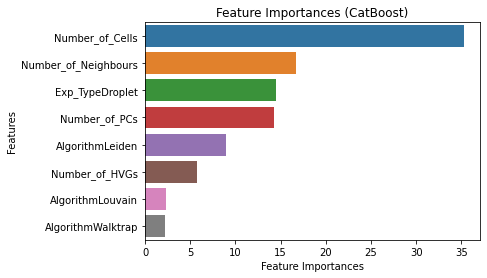

In [21]:
import seaborn as sns

feature_imp = pd.Series(catb_tuned.feature_importances_,
                        index=X_train.columns).sort_values(ascending=False)

sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importances')
plt.ylabel('Features')
plt.title("Feature Importances (CatBoost)")
plt.show()

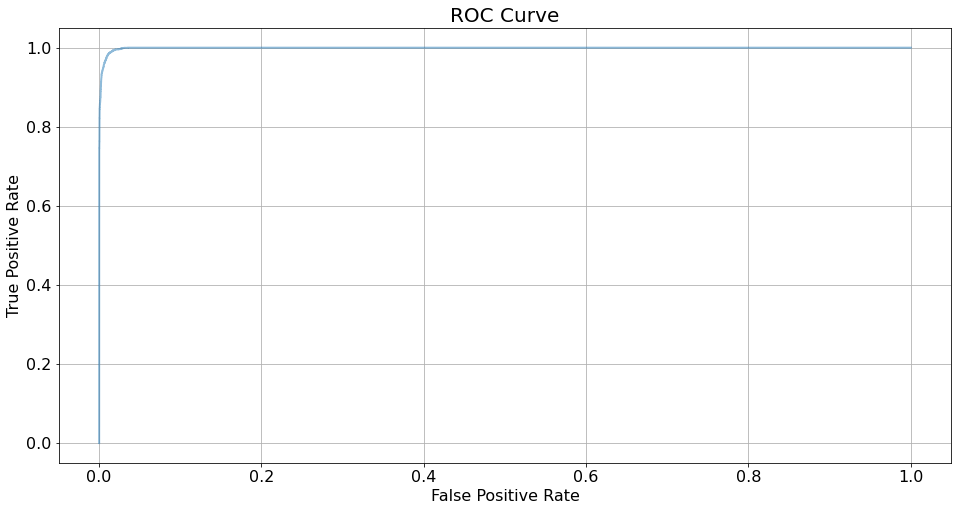

In [26]:
from catboost.utils import get_roc_curve
catboost_pool = Pool(X_train, y_train)
(fpr, tpr, thresholds) = get_roc_curve(catb_tuned, catboost_pool, plot=True)

In [28]:
print(fpr)
print(tpr)

[0.         0.         0.         ... 0.99983429 0.99991714 1.        ]
[0.00000000e+00 7.19165768e-04 1.07874865e-03 ... 1.00000000e+00
 1.00000000e+00 1.00000000e+00]


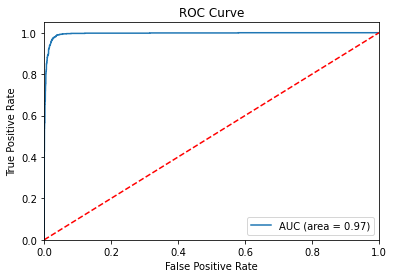

In [30]:
logit_roc_auc = roc_auc_score(y_test, catb_tuned.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, catb_tuned.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='AUC (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()